### 🧠 Make More v4.0 – Modular PyTorch Implementation with Kaiming Init & Smoothed Logits

#### 🔍 Goal
In v4.0, we:

- Refactor the architecture into reusable PyTorch modules (Linear, BatchNorm1d, Tanh, etc.)

- Use Kaiming initialization to stabilize activations

- Introduce with torch.no_grad() tweaks to smooth final logits

- Apply step learning rate decay to improve long-term optimization

- Make the model architecture easily extensible to deeper MLPs or new layer

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from networkx.classes import non_edges
from sympy import hermite_prob
from torch import nn
# from Transformers.NanoGPT import vocab_size
%matplotlib inline


In [4]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 3]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 3]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 3]), Yte: torch.Size([22706])


In [8]:
print(Xtr.size(), Ytr.size(), Xte.size(), Yte.size())

torch.Size([182594, 3]) torch.Size([182594]) torch.Size([22706, 3]) torch.Size([22706])


<img src="Transformers/images/img.png">

In [9]:
n_embd = 10  # dimensionality of the character level embedding vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2323938434709) # for reproducibility
# look up table --> 2-10 (increasing embedding dim)
C = torch.rand(vocab_size, n_embd,                      generator=g)
# here (5/3)/(sqrt(fan_nodes))--- kaiming init for this weight initialization
W1 = torch.randn((n_embd*block_size, n_hidden),         generator=g)* (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                              generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g)* 0.01
b2 = torch.randn(vocab_size,                            generator=g)* 0

# Batch Norm parameters
#--------------------------
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
#---------->># for single example input in inference----
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)
# --------------------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total_parameters :{sum(p.nelement() for p in parameters)}") # total num of parameters

for p in parameters:\
    p.requires_grad = True

Total_parameters :12097


In [11]:
# Training a Neural Net
epochs = 200000
batch_size = 32
lossi = []

for epoch in range(epochs):
    # Mini_batch Constructor------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # Forward pass ------------------------------------
    emb = C[Xb]  # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # Linear Layer before applying Non-linearity ------------
    hpreat = embcat @ W1  # + b1  # hiden layer pre activations

    # Batch Normalization Layer ------------------------
    bnmeani = hpreat.mean(0, keepdim= True)
    bnstdi = hpreat.std(0, keepdim=True)
    hpreat = bngain *(hpreat - bnmeani)/bnstdi + bnbias # we can add E for zero division error

    # Traking  bnmean and bnstd for inference ---------
    with torch.no_grad():
        bnmean_running = 0.999* bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999* bnstd_running + 0.001*bnstdi

    # Non- Linearity ---------------------------------------
    h = torch.tanh(hpreat)  # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass ----------------------------------------
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters --------------------------------------
    # lr = lrs[i]
    lr = 0.1 if epoch < 100000 else 0.01
    for p in parameters:
        learning_rate = -lr
        p.data += learning_rate * p.grad

    # tracking status -----------------------------------------
    # lri.append(lre[i])
    if epoch % 10000 ==0:
        print(f'epoch :{epoch:7d}/{epochs:7d}: loss {loss.item():.4f}')
    #
    lossi.append(loss.log10().item())



epoch :      0/ 200000: loss 3.2824
epoch :  10000/ 200000: loss 2.5701
epoch :  20000/ 200000: loss 2.4154
epoch :  30000/ 200000: loss 2.4425
epoch :  40000/ 200000: loss 1.9790
epoch :  50000/ 200000: loss 2.4864
epoch :  60000/ 200000: loss 1.8767
epoch :  70000/ 200000: loss 1.8811
epoch :  80000/ 200000: loss 2.1519
epoch :  90000/ 200000: loss 2.2956
epoch : 100000/ 200000: loss 2.2290
epoch : 110000/ 200000: loss 1.9589
epoch : 120000/ 200000: loss 2.3025
epoch : 130000/ 200000: loss 1.5771
epoch : 140000/ 200000: loss 2.0039
epoch : 150000/ 200000: loss 2.1351
epoch : 160000/ 200000: loss 1.9827
epoch : 170000/ 200000: loss 1.6170
epoch : 180000/ 200000: loss 2.0604
epoch : 190000/ 200000: loss 1.8893


## =========================
## Validation & Training loss on Overall data
## =========================

In [13]:
@torch.no_grad() # decorator helps to disable gradient traking during backward pass
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'valid' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreat = embcat @ W1 # + b1
    hpreat = bngain *(hpreat - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreat)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss :{loss.item()}')

split_loss("train")
split_loss("valid")

train loss :2.0677595138549805
valid loss :2.1182148456573486


---

## 📊 Training Improvements Summary

We iteratively refined our model using several architectural and initialization enhancements. Below is a comparison of **training and validation loss** across different stages:

| Change Made                                       | Train Loss | Validation Loss |
|--------------------------------------------------|------------|-----------------|
| 🔹 **Original**                                   | 2.1245     | 2.1682          |
| 🔧 Fix: Softmax was confidently wrong             | 2.0750     | 2.1316          |
| 🔧 Fix: `tanh` layer too saturated at init        | 2.0697     | 2.1185          |
| 📐 Use: Semi-principled **Kaiming Initialization**| 2.0377     | 2.1070          |
| 🧪 Add: **Batch Normalization**                   | 2.0694     | 2.1185          |

---

### 🧠 Observations

- Each modification led to **gradual improvements** in train and validation loss.
- However, since we’re working with a **small dataset**, the gains are **limited and sometimes marginal**.
- **Batch normalization**, while powerful in deeper networks, may not show major benefits in this shallow architecture.




# Pytorching the code

In [63]:
# -------Linear Layer -----------
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g)/ (in_features)**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -------Batch Norm Layer -----------

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training =True
        # parameters (which are trained )
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trainned with momentum updating)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ---- TanH layer =-------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


### Deeper Network

In [84]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147434123517) # for reproducibility

# network-------------------
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
 Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # making the last linear layer less confident
    layers[-1].gamma *=0.1
    # applying gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=1 # kaiming init to stablize the activations

#_--------------Parameters------------------------
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [85]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3252


---

### 📊 Activation Distribution Plot (Tanh Layers)
#### 🔍 Purpose
- This histogram plot visualizes the distribution of activations after each Tanh nonlinearity across different layers. It's a crucial tool to:

- Ensure activations are centered (mean ~ 0)

- Ensure they're not too saturated (i.e., not stuck near -1 or +1)

- Confirm that standard deviation is reasonable (not exploding or vanishing)

What’s being plotted:
Each line on the plot corresponds to one Tanh layer’s activations across the batch:
``` python
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
```
- t = output tensor of a Tanh layer during the forward pass

- hx: x-axis = value of activations (should range from -1 to 1)

- hy: y-axis = normalized frequency of those activation values

The plot gives you a layer-wise comparison of how your model’s non-linear activations behave.



layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.81%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.31%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.03%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.78%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.41%


Text(0.5, 1.0, 'activation distribution')

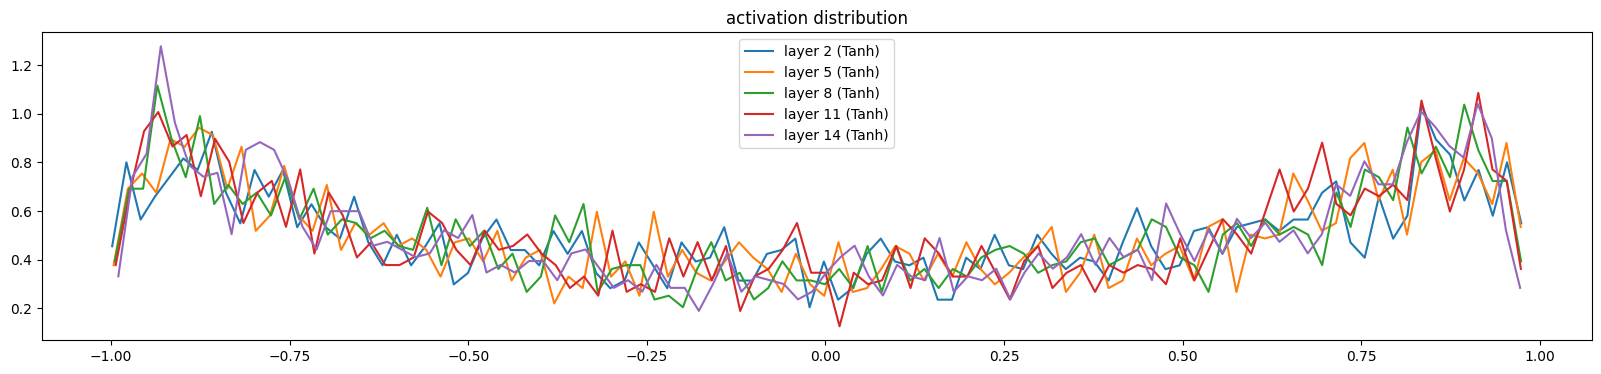

In [86]:
# Visualize the hist grams
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

| Metric        | Meaning                                                       |
| ------------- | ------------------------------------------------------------- |
| `mean ±0.00`  | Activations are nicely centered around 0 (ideal for `tanh`)   |
| `std ~0.63`   | Reasonable spread of activations; not too flat or explosive   |
| `saturated %` | Percentage of outputs close to ±1 (outside ±0.97); low = good |

- Low saturation is important because:

- Saturated neurons (outputs near -1 or +1) lead to vanishing gradients

- This hinders learning since their derivatives are almost 0

Our outputs show excellent behavior: low saturation (<3%), centered activations, and good spread — indicating Kaiming initialization and BatchNorm are doing their job well.


---

### 📊 Gradient Distribution Plot (Tanh Layer Outputs)
#### 🔍 Purpose
This plot helps you diagnose the backpropagation process by visualizing the gradient of the output of each Tanh layer (i.e., layer.out.grad).

Ensures gradients are non-zero

Helps detect vanishing gradients

Confirms whether earlier layers receive meaningful updates



#### What's Being Plotted

Each line on the plot is the histogram of gradient values flowing through the output of a specific Tanh layer:
```python
t = layer.out.grad  # gradient of layer's output
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
```


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

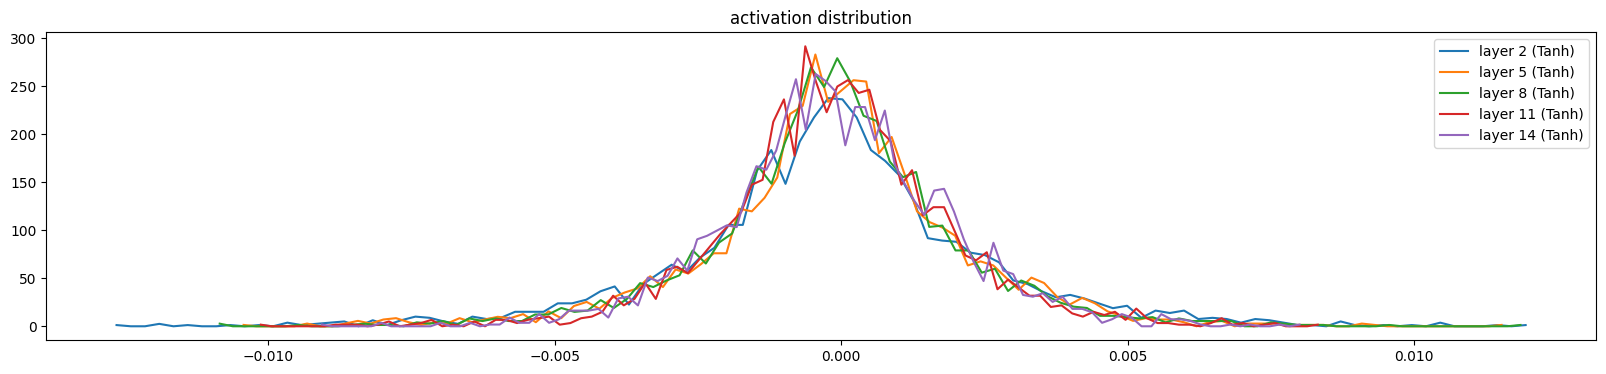

In [87]:
# Visualize the hist grams of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 8.882700e-03 | grad:data ratio 8.906716e-03
weight  (30, 100) | mean +0.000038 | std 1.108643e-02 | grad:data ratio 6.087960e-02
weight (100, 100) | mean +0.000040 | std 7.557061e-03 | grad:data ratio 7.394013e-02
weight (100, 100) | mean -0.000029 | std 6.482827e-03 | grad:data ratio 6.346844e-02
weight (100, 100) | mean +0.000059 | std 5.982013e-03 | grad:data ratio 5.869290e-02
weight (100, 100) | mean +0.000068 | std 5.321154e-03 | grad:data ratio 5.240336e-02
weight  (100, 27) | mean -0.000001 | std 1.088539e-02 | grad:data ratio 1.046129e-01


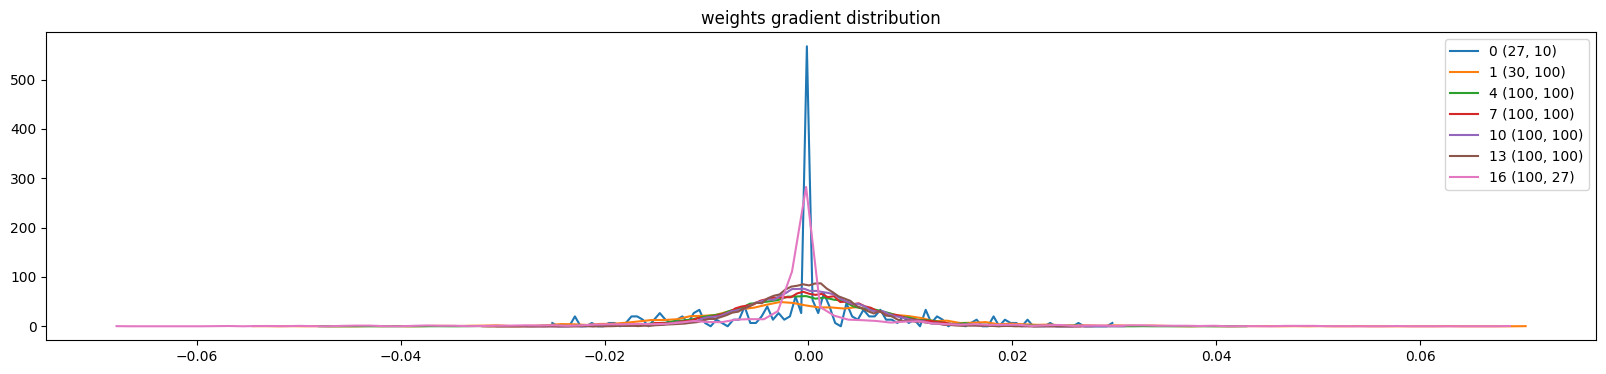

In [88]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### Interpretation of Plot
Gradients are well-distributed: No vanishing or exploding gradients — good stability across layers.

Grad:Data Ratios are healthy:

Most are in the 5–10% range.

Final linear layer (100, 27) has the highest ratio (~10%), which is expected as output layers tend to have larger gradients.

Symmetric histograms: Shows balanced updates — no bias toward positive or negative gradients.

---

### 📊 Gradient-to-Data Ratio Over Training
#### 🔍 What It Is:
This plot shows the log-scale trend of the ratio between gradient magnitude and parameter magnitude (called the "update-to-data ratio") during training for each weight matrix in your neural network.

#### 🧠 Why It Matters:
The gradient-to-data ratio (or update-to-weight ratio) is a measure of how much each parameter is changing relative to its own scale. A commonly recommended target is:

#### ✅ Ratio ≈ 1e-3

This ensures that:

- Gradients aren't vanishing (too small to make a difference),

- And they're not exploding (making updates too aggressively).

#### 🧰 What the Plot Shows:
Each line represents a different weight matrix (e.g., layer weights).

- X-axis: Training steps (iterations or epochs).

- Y-axis: log10(gradient std / weight std) for each parameter.

Dashed horizontal line at -3: This is your target region for good gradient flow.





#### ✅ How You Can Use This:
Health Check for Training Dynamics:

- If ratios hover around -3, your model is updating well.

- If much lower (e.g., -5), your updates are too weak → risk of underfitting.

- If much higher (e.g., -1), updates are too aggressive → risk of instability.

Tuning Learning Rate:

- If most ratios are too high, consider lowering the learning rate.

- If too low, increase the learning rate.

- Monitoring Initialization & Scaling:

Helps validate if your Kaiming initialization or normalization strategies are working as intended.

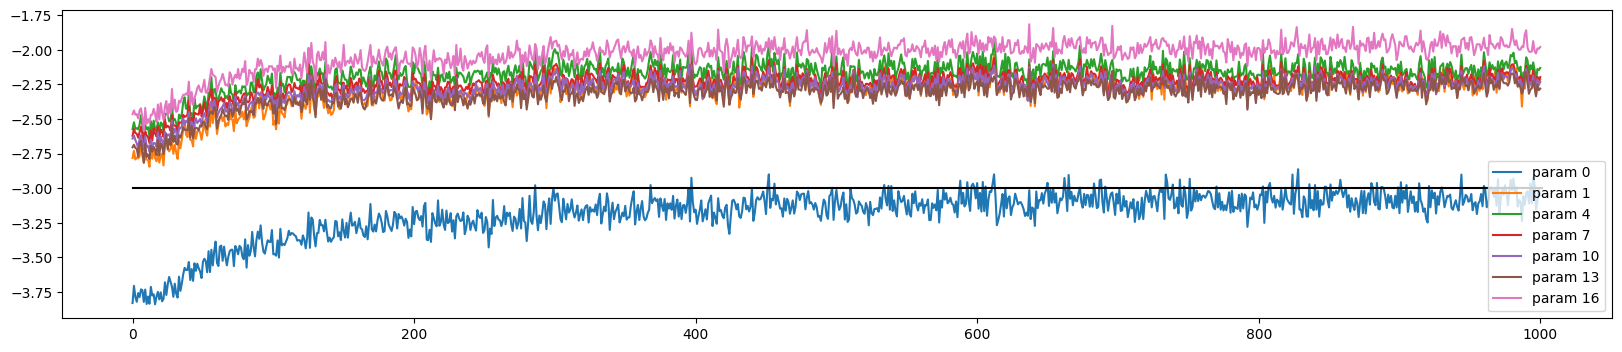

In [89]:
# update gradient to data ratio hist plot
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    # intializing with all zeros [0,0,0] (...)
    context = [0] * block_size
    while True:
        # forward pass to the nerual network
        embed = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(embed.view(1, -1) @ W1 )# +b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sampling from the distribution using multinomial
        ix = torch.multinomial(probs, num_samples=1, generator=g)

        # shifting the context window ... ---> e ==> ..e --> m
        context = context[1:] + [ix]
        out.append(ix.item())
        # if the sample is special token (.) break
        if ix ==0:
            break
    # decoding the output embeddings
    print(''.join(itos[i] for i in out))

oreaaix.
h.
.
h.
.
.
h.
.
hr.
.
htdtlaesaadskejeaoennaaunty.
t.
.
hedi.
.
h.
ouintciriivdv.
.
h.
.
